Goal : Create a sklearn data pipeline to take the data from my matlab struct, convert it to a pandas data frame, clean and scale/standardize it. Create a sklearn estimator using psytrack to be able to use randomized search to optimize the hyperparameters of the model. Maybe also use a recursive feature elimination (https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py) to determine the optimal attributes to fir the data.

In [1]:
folderpath = r'/Users/rebeccakrall/Downloads';
animal = 'c_129';

In [2]:
def mat_struct_2_pd(folderpath, file):
    import pandas as pd
    import os
    from scipy.io import loadmat
    import numpy as np

    file_data = 'analyze_animal_'+file+'.mat'
    path = os.path.join(folderpath,file_data);
    mouse_mat = loadmat(path, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    
    m = mouse_mat['animal']
    beh = pd.DataFrame((m.lick.T).astype(bool))
    beh.columns = ['RH', 'LH', 'RM', 'LM', 'NG']
    beh['LED'] = (m.LED).astype(bool)
    beh['Session'] = m.sessionNum
    beh['Stimulus'] = m.stimulus
    beh['Target'] = m.target 

    file_ttl = 'ttl_info_'+file+'.mat'
    ttl_path = os.path.join(folderpath, file_ttl)
    mouse_ttl = loadmat(ttl_path, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    beh['Spout_1']= np.mean(mouse_ttl['trial_info'].lick[:,750:825,0],axis = 1)
    beh['Spout_2'] = np.mean(mouse_ttl['trial_info'].lick[:,750:825,1],axis = 1)

    file_training = 'analyze_training_'+file+'.mat'
    training_path = os.path.join(folderpath, file_training)
    mouse_train = loadmat(training_path,struct_as_record = False, squeeze_me = True, mat_dtype = True)
    
    train = mouse_train['training']
    tdata = {'trials_opto': [train.trials_opto], 'trials_prof': [train.trials_proficient],
        'trials_expert': [train.trials_expert], 'days_opto': [train.days_opto],
        'days_prof':[train.days_proficient], 'days_expert': [train.days_expert]}
    
    t = pd.DataFrame(tdata)


    

    return beh, t


In [3]:
b,t = mat_struct_2_pd(folderpath, animal)

In [4]:
def clean_behavior_data(b):
    import numpy as np
    import pandas as pd

    b2 = b.copy()
    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    b2['Previous_rightward'] = np.concatenate(([0], b2['Rightward'][:-1].values))
    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    b2['Previous_correct'] = np.concatenate(([0], b2['Correct'][:-1].values))
    b2['Stimulus'] =np.log2(b['Stimulus']/8)/2
    b2['New_session']= np.array(np.append(1, np.diff(b['Session'])), dtype = bool)
    

    b2.iloc[b2['New_session'], b2.columns.get_loc("Previous_rightward")] = 0
    b2.iloc[b2['New_session'], b2.columns.get_loc("Previous_correct")] = 0
    go = (b['RH'] | b['LM'] | b['RM'] | b['LH']).values
    
    b2 = b2.iloc[go,:]
    b2 = b2.drop(["RH", "RM", "LH", "LM", "NG"], axis = 1)
    
    return b2

In [5]:
b2 = clean_behavior_data(b)
import numpy as np
b2

,LED,Session,Stimulus,Target,Spout_1,Spout_2,Rightward,Previous_rightward,Correct,Previous_correct,New_session
37,False,1.0,1.00,0.0,0.000000,0.0,0,0,1,0,False
38,False,1.0,-1.00,0.0,0.000000,0.0,0,0,1,1,False
39,False,1.0,1.00,0.0,0.573333,0.0,0,0,1,1,False
41,False,1.0,1.00,0.0,0.466667,0.0,0,0,1,0,False
43,False,1.0,1.00,0.0,0.000000,0.0,0,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...
7688,False,19.0,-0.50,0.0,0.000000,0.0,1,1,0,1,False
7689,False,19.0,0.00,0.0,0.000000,0.0,1,1,0,0,False
7690,True,19.0,-0.50,0.0,0.000000,0.0,1,1,0,0,False
7692,False,19.0,-0.25,0.0,0.000000,0.0,1,0,0,0,False


In [6]:
dayLength=np.array(b2.groupby(['Session']).size())
dayLength

array([522, 461, 445, 393, 344, 356, 318, 231, 327, 181, 193, 429, 373,
       351, 308, 462, 455, 204, 316])

In [7]:
# stimulus
# LED
import numpy as np

inputs = dict(stim = np.expand_dims(np.array(b2['Stimulus']), axis=1),
    LED = np.expand_dims(np.array(b2['Stimulus']).astype(int), axis=1)
)   


dat = dict(
        subject = animal,
        inputs = inputs,
        correct = np.array(b2['Correct']),
        answer = np.array(b2['Target']),
        y = np.array(b2['Rightward']),
        dayLength=np.array(b2.groupby(['Session']).size()),
    )

In [8]:
import os
import re
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
import numpy as np
import pandas as pd

import psytrack_learning as psy
from psytrack_learning.getMAP import getMAP
from psytrack_learning.helper.helperFunctions import update_hyper, hyper_to_list
from psytrack_learning.helper.jacHessCheck import compHess, compHess_nolog
from psytrack_learning.helper.invBlkTriDiag import getCredibleInterval
from psytrack_learning.hyperparameter_optimization import evd_lossfun
from psytrack_learning.learning_rules import RewardMax, PredictMax, REINFORCE, REINFORCE_base
from psytrack_learning.simulate_learning import reward_max, predict_max, reinforce, reinforce_base 
from psytrack_learning.simulate_learning import simulate_learning

In [9]:

rec_learning_rule = REINFORCE
weights = {'bias' : 1, 'stim' :1, 'LED': 1}
K = np.sum([weights[i] for i in weights.keys()])
hyper_guess = {
    'alpha': [2**-6] * K,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for both sigma and alpha simultaneously
optList = ['sigma', 'alpha']


# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": dat, "K": K, "learning_rule": REINFORCE,
        "hyper": hyper_guess, "weights": weights, "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, weights, W0=None,
                                    learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)
wMode = wMode.reshape((K, -1), order="C")

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, "W_std": W_std, "wMode": wMode}

    [-4. -4. -4. -6. -6. -6.] 1 2246.484 
    [-3. -4. -4. -6. -6. -6.] 2 2257.863 
    [-4. -3. -4. -6. -6. -6.] 3 2224.877 
    [-4. -3. -3. -6. -6. -6.] 4 2234.314 
    [-4. -3. -4. -5. -6. -6.] 5 2226.082 
    [-4. -3. -4. -6. -5. -6.] 6 2221.859 
    [-4. -3. -4. -6. -5. -5.] 7 2223.082 
    [-4.431 -2.182 -4.357 -6.046 -4.886 -6.046] 8 2217.209 
    [-3.577 -1.71  -4.563 -6.072 -4.82  -6.073] 9 2234.874 
    [-5.242 -2.565 -4.772 -6.099 -4.753 -6.1  ] 10 2212.007 
    [-5.894 -2.408 -4.04  -6.141 -4.647 -6.143] 11 2215.595 
    [-5.207 -2.573 -4.769 -6.597 -4.753 -6.1  ] 12 2210.878 
    [-5.444 -2.501 -5.621 -6.876 -4.413 -6.238] 13 2210.531 
    [-5.568 -2.47  -5.756 -6.923 -4.875 -6.258] 14 2213.533 
    [-5.472 -2.448 -5.644 -6.879 -4.406 -5.996] 15 2210.711 
    [-5.384 -2.966 -5.627 -6.929 -4.27  -6.157] 16 2211.98 
    [-5.214 -2.481 -5.706 -6.861 -4.451 -6.223] 17 2211.364 
    [-5.512 -2.247 -5.412 -7.003 -4.078 -6.332] 18 2209.62 
    [-5.626 -2.182 -5.451 -6.559 -3.9  

In [54]:
inputs['stim'].shape

(6669, 1)

In [11]:
np.savez_compressed(folderpath+'fig2a_data_rec.npz', rec_dat=rec_dat)

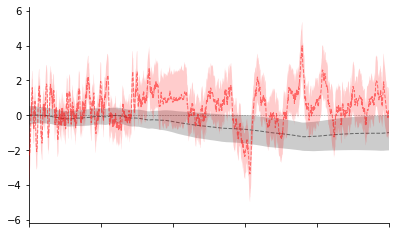

In [16]:
fig = plt.figure(figsize=(5,3))
sim_colors = [[0, 0, 0], [1, 0, 0]]

for i, c in enumerate(sim_colors):
    #plt.plot(gen_dat['W'][i], c=c, lw=0.5, zorder=2*i)
    plt.plot(rec_dat['wMode'][i], c=c, lw=1, linestyle='--', alpha=0.5, zorder=2*i+1)
    plt.fill_between(np.arange(len(rec_dat['wMode'][i])),
                     rec_dat['wMode'][i] - 2 * rec_dat['W_std'][i],
                     rec_dat['wMode'][i] + 2 * rec_dat['W_std'][i],
                     facecolor=c, alpha=0.2, zorder=2*i+1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

plt.gca().set_xticklabels([])
plt.yticks(np.arange(-6,7,2))
plt.xlim(0,5000); plt.ylim(-6.2,6.2)
# plt.xlabel("Trials"); plt.ylabel("Weights")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 

NameError: name 'true_hyper' is not defined